### Toronto Neighborhoods Segementation and Clustering

#### Part 1 (Getting the dataset)

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [2]:
src=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=BeautifulSoup(src,'lxml')
txt=soup.prettify()

By looking at the text scraped from the webpage we extract the postal codes table by finding the associated tag

In [3]:
table=soup.find('table',class_='wikitable')
tab_rows=table.find_all('td')

Each td tag is used to obtain the row data and is later converted to a pandas dataframe.

In [4]:
postc=[]
bor=[]
nbh=[]
for i in range(0,len(tab_rows),3):
    postc.append(tab_rows[i].text.strip())
    bor.append(tab_rows[i+1].text.strip())
    nbh.append(tab_rows[i+2].text.strip())
df_toronto=pd.DataFrame(data=[postc,bor,nbh]).transpose()
df_toronto.columns=['Postal Code','Borough','Neighborhood']
df_toronto.head()
    

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


Boroughs Not assigned are removed from the dataframe

In [5]:
df_toronto=df_toronto[df_toronto['Borough']!='Not assigned']
df_toronto.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [6]:
df_toronto['Neighborhood'] = df_toronto['Neighborhood'].apply(lambda x: x.replace('/', ','))
df_toronto

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park , Harbourfront"
5,M6A,North York,"Lawrence Manor , Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway , Montgomery Road , Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,Business reply mail Processing CentrE
169,M8Y,Etobicoke,"Old Mill South , King's Mill Park , Sunnylea ,..."


.shape is used as instructed to ensure that we end up with 103 records in our dataframe

In [7]:
df_toronto.shape

(103, 3)

#### Part 2 (Getting latitude and longitude)

We load the data from the given csv file containing the geo coordinates for every postal code and merge the columns with our initial dataframe

In [8]:
df_ll=pd.read_csv('http://cocl.us/Geospatial_data')
df_toronto=pd.merge(df_toronto,df_ll,on=['Postal Code'],how='inner')

In [9]:
df_toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


#### Part 3 (Clustering the neighbourhoods in Toronto and Analysis)

We are to segment the neighborhoods in Toronto so we will take only the Boroughs which contain the word 'Toronto' in them 

In [10]:
df_toronto = df_toronto[df_toronto['Borough'].str.contains("Toronto")] 
df_toronto.head()
dft1=df_toronto

In [11]:
tmp=[]
tl=[]
tmp=list(dft1['Neighborhood'])
for i in tmp:
    tl.append(i.split(",")[0])
dft1['Neighborhood']=tl
dft1.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
9,M5B,Downtown Toronto,Garden District,43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


Since we have our dataset now, we will move onto visualization and clustering

In [14]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Using the geopy library we get the latitude and longitude of Toronto

In [15]:
address = 'Toronto,Canada'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


In [16]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, label in zip(dft1['Latitude'], dft1['Longitude'], dft1['Borough'], dft1['Neighborhood']):
    label = '{}, {}'.format(dft1, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Defining Foursquare Credentials

In [36]:
CLIENT_ID = 'Your client_id' # your Foursquare ID
CLIENT_SECRET = 'your client_secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Your client_id
CLIENT_SECRET:your client_secret


In [18]:
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Using the function defined above we will get the nearby venues of all the neighborhoods with the help of Foursquare API calls

In [19]:
tor_venues = getNearbyVenues(names=dft1['Neighborhood'],
                                   latitudes=dft1['Latitude'],
                                   longitudes=dft1['Longitude']
                                  )
tor_venues.head()

Regent Park 
Queen's Park 
Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond 
Dufferin 
Harbourfront East 
Little Portugal 
The Danforth West 
Toronto Dominion Centre 
Brockton 
India Bazaar 
Commerce Court 
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park 
North Toronto West
The Annex 
Parkdale 
Davisville
University of Toronto 
Runnymede 
Moore Park 
Kensington Market 
Summerhill West 
CN Tower 
Rosedale
Stn A PO Boxes
St. James Town 
First Canadian Place 
Church and Wellesley
Business reply mail Processing CentrE


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Regent Park,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Regent Park,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Regent Park,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,Regent Park,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Regent Park,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


Let's check how many venues were returned for each neighborhood

In [20]:
tor_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,55,55,55,55,55,55
Brockton,23,23,23,23,23,23
Business reply mail Processing CentrE,16,16,16,16,16,16
CN Tower,14,14,14,14,14,14
Central Bay Street,64,64,64,64,64,64
Christie,18,18,18,18,18,18
Church and Wellesley,75,75,75,75,75,75
Commerce Court,100,100,100,100,100,100
Davisville,34,34,34,34,34,34


Next we will analyze each neighborhood

In [22]:
# one hot encoding
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tor_onehot['Neighborhood'] =tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
toronto_onehot = tor_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [23]:
tor_grouped = tor_onehot.groupby('Neighborhood').mean().reset_index()
tor_grouped

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Brockton,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Business reply mail Processing CentrE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,CN Tower,0.071429,0.071429,0.071429,0.142857,0.142857,0.142857,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00,0.015625,0.000000,0.000000,0.015625,0.000000,0.000000,0.015625
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013333,0.000000,0.00,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026667
7,Commerce Court,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,...,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.029412,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Let's print each neighborhood along with the top 10 most common venues

In [24]:
num_top_venues = 10

for hood in tor_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = tor_grouped[tor_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.05
1      Farmers Market  0.04
2        Cocktail Bar  0.04
3          Restaurant  0.04
4            Beer Bar  0.04
5              Bakery  0.04
6  Seafood Restaurant  0.04
7  Italian Restaurant  0.04
8         Cheese Shop  0.04
9                Café  0.04


----Brockton ----
                   venue  freq
0                   Café  0.13
1         Breakfast Spot  0.09
2            Coffee Shop  0.09
3                 Bakery  0.04
4              Pet Store  0.04
5      Convenience Store  0.04
6  Performing Arts Venue  0.04
7             Restaurant  0.04
8              Nightclub  0.04
9           Climbing Gym  0.04


----Business reply mail Processing CentrE----
                  venue  freq
0            Comic Shop  0.06
1         Garden Center  0.06
2                  Park  0.06
3            Restaurant  0.06
4        Farmers Market  0.06
5  Fast Food Restaurant  0.06
6            Skate Park  0.06
7               Butcher

We shall now put this into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [26]:
import numpy as np
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tor_grouped['Neighborhood']

for ind in np.arange(tor_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tor_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Farmers Market,Cheese Shop,Beer Bar,Bakery,Café,Restaurant,Italian Restaurant,Seafood Restaurant,Cocktail Bar
1,Brockton,Café,Breakfast Spot,Coffee Shop,Grocery Store,Bakery,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue
2,Business reply mail Processing CentrE,Skate Park,Pizza Place,Butcher,Burrito Place,Fast Food Restaurant,Farmers Market,Auto Workshop,Spa,Restaurant,Garden
3,CN Tower,Airport Lounge,Airport Service,Airport Terminal,Airport,Airport Food Court,Airport Gate,Boutique,Harbor / Marina,Boat or Ferry,Sculpture Garden
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Spa,Ice Cream Shop,Japanese Restaurant,Sushi Restaurant,Bubble Tea Shop,Salad Place


We will now use the K-Means clustering algorithm on this data to cluster and segment the neighborhoods

In [27]:
tor_grouped_clustering = tor_grouped.drop('Neighborhood', 1)

To identify the optimal number of clusters we shall plot an elbow curve.

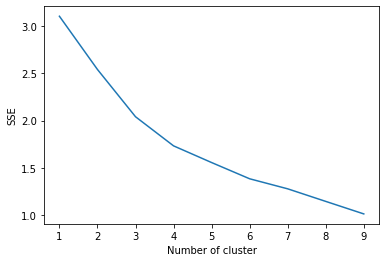

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(tor_grouped_clustering)
    tor_grouped_clustering["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_  
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [29]:
kclusters=4
kmeans_final= KMeans(n_clusters=4, max_iter=100).fit(tor_grouped_clustering)

In [30]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_final.labels_)
tor_merged = dft1
tor_merged = tor_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
tor_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Pub,Mexican Restaurant,Breakfast Spot,Café,Restaurant,Theater,Shoe Store
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,0,Coffee Shop,Diner,Fried Chicken Joint,Burrito Place,Juice Bar,Sandwich Place,Café,Italian Restaurant,Beer Bar,Mexican Restaurant
9,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Japanese Restaurant,Italian Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Bookstore,Restaurant
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Cocktail Bar,Restaurant,Beer Bar,American Restaurant,Hotel,Italian Restaurant,Seafood Restaurant,Park
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Health Food Store,Trail,Pub,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


Finally, let's visualize the resulting clusters

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], tor_merged['Neighborhood'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

By examining the resulting clusters we can now see the corresponding labels

Cluster 1

In [32]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,0,Coffee Shop,Park,Bakery,Pub,Mexican Restaurant,Breakfast Spot,Café,Restaurant,Theater,Shoe Store
4,Downtown Toronto,0,Coffee Shop,Diner,Fried Chicken Joint,Burrito Place,Juice Bar,Sandwich Place,Café,Italian Restaurant,Beer Bar,Mexican Restaurant
9,Downtown Toronto,0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Japanese Restaurant,Italian Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Bookstore,Restaurant
15,Downtown Toronto,0,Coffee Shop,Café,Cocktail Bar,Restaurant,Beer Bar,American Restaurant,Hotel,Italian Restaurant,Seafood Restaurant,Park
20,Downtown Toronto,0,Coffee Shop,Farmers Market,Cheese Shop,Beer Bar,Bakery,Café,Restaurant,Italian Restaurant,Seafood Restaurant,Cocktail Bar
24,Downtown Toronto,0,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Spa,Ice Cream Shop,Japanese Restaurant,Sushi Restaurant,Bubble Tea Shop,Salad Place
25,Downtown Toronto,0,Grocery Store,Café,Park,Coffee Shop,Nightclub,Italian Restaurant,Candy Store,Baby Store,Athletics & Sports,Restaurant
30,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Gym,Thai Restaurant,Hotel,Deli / Bodega,Bar,Sushi Restaurant,Pizza Place
31,West Toronto,0,Pharmacy,Bakery,Grocery Store,Recording Studio,Café,Supermarket,Middle Eastern Restaurant,Bar,Bank,Brewery
36,Downtown Toronto,0,Coffee Shop,Aquarium,Hotel,Restaurant,Italian Restaurant,Café,Brewery,Sporting Goods Shop,Scenic Lookout,Fried Chicken Joint


Cluster 2

In [33]:
tor_merged.loc[tor_merged['Cluster Labels'] == 1, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,East Toronto,1,Health Food Store,Trail,Pub,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
67,Central Toronto,1,Park,Breakfast Spot,Gym,Food & Drink Shop,Sandwich Place,Department Store,Hotel,Discount Store,Ethiopian Restaurant,Electronics Store
91,Downtown Toronto,1,Park,Playground,Trail,Yoga Studio,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


Cluster 3

In [34]:
tor_merged.loc[tor_merged['Cluster Labels'] == 2, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Central Toronto,2,Park,Swim School,Bus Line,Yoga Studio,Diner,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
83,Central Toronto,2,Playground,Trail,Tennis Court,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


Cluster 4

In [35]:
tor_merged.loc[tor_merged['Cluster Labels'] == 3, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Central Toronto,3,Home Service,Garden,Yoga Studio,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
87,Downtown Toronto,3,Airport Lounge,Airport Service,Airport Terminal,Airport,Airport Food Court,Airport Gate,Boutique,Harbor / Marina,Boat or Ferry,Sculpture Garden
